In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.8 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.data import Data, Batch
from torch_geometric.nn import SAGEConv
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.models import vit_b_16, ViT_B_16_Weights
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [ ]:

# Focal Loss Implementation
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha, (float, int)):
            self.alpha = torch.Tensor([alpha, 1-alpha])
        if isinstance(alpha, list):
            self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim() > 2:
            input = input.view(input.size(0), input.size(1), -1)
            input = input.transpose(1, 2)
            input = input.contiguous().view(-1, input.size(2))
        target = target.view(-1, 1)
        logpt = F.log_softmax(input, dim=1)
        logpt = logpt.gather(1, target)
        logpt = logpt.view(-1)
        pt = logpt.data.exp()

        if self.alpha is not None:
            if self.alpha.type() != input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0, target.data.view(-1))
            logpt = logpt * at

        loss = -1 * (1 - pt) ** self.gamma * logpt
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()


In [ ]:
class CNN_GNN_ViT(nn.Module):
    def __init__(self, num_classes):
        super(CNN_GNN_ViT, self).__init__()
        self.vit = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
        in_features = self.vit.heads.head.in_features
        self.vit.heads.head = nn.Linear(in_features, 256)
        self.conv1 = SAGEConv(256, 128)
        self.conv2 = SAGEConv(128, num_classes)

    def forward(self, x, edge_index, batch):
        x = self.vit(x)  # Feature Extraction with Vision Transformer
        x = self.conv1(x, edge_index)  
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)  
        return F.log_softmax(x, dim=1)


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

data_dir = "/content/drive/MyDrive/MPox/MonkeyPoxSkinLesionDataset"
dataset = ImageFolder(root=data_dir, transform=transform)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)
class_names = dataset.classes


In [ ]:
class_names

['Monkeypox', 'Others']

In [ ]:
def create_graph_data(features, labels=None):
    num_nodes = features.size(0)
    edge_index = torch.combinations(torch.arange(num_nodes), r=2).t()
    x = features.clone().detach()
    y = labels.clone().detach() if labels is not None else None
    return Data(x=x, edge_index=edge_index, y=y)


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
# Building a Model Using Vision Transformer and GNN Layers
model = CNN_GNN_ViT(num_classes=len(class_names)).to(device)
# Loss Function and Optimization Settings with Focal Loss
criterion = FocalLoss(gamma=2, alpha=[0.25] * len(class_names))
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:05<00:00, 65.1MB/s]


In [ ]:
device.type

'cuda'

In [ ]:
def train(epochs=20):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, batch in enumerate(data_loader):
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            data = create_graph_data(images, labels)
            data = data.to(device)

            optimizer.zero_grad()
            output = model(data.x, data.edge_index, data.batch)
            loss = criterion(output, data.y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        scheduler.step()
        avg_loss = running_loss / len(data_loader)
        train_losses.append(avg_loss)
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}, Accuracy: {train_accuracy:.2f}%")

        # Validation Accuracy and Loss Calculation
        val_loss, val_accuracy = validate()
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

    # Plotting graphs after training
    plot_training_graphs(train_losses, val_losses, train_accuracies, val_accuracies)

def validate():
    model.eval()
    correct_val = 0
    total_val = 0
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            data = create_graph_data(images, labels)
            data = data.to(device)

            output = model(data.x, data.edge_index, data.batch)
            loss = criterion(output, labels)
            running_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_loss = running_loss / len(data_loader)
    accuracy = 100 * correct_val / total_val
    return avg_loss, accuracy

def plot_roc_curve():
    model.eval()
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            data = create_graph_data(images, labels)
            data = data.to(device)

            output = model(data.x, data.edge_index, data.batch)
            probs = F.softmax(output, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(all_labels == i, all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    for i in range(len(class_names)):
        plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix():
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            data = create_graph_data(images, labels)
            data = data.to(device)

            output = model(data.x, data.edge_index, data.batch)
            _, predicted = torch.max(output.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def plot_training_graphs(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure()
    plt.plot(epochs, train_losses, 'r', label='Training loss')
    plt.plot(epochs, val_losses, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(epochs, train_accuracies, 'r', label='Training accuracy')
    plt.plot(epochs, val_accuracies, 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

def calculate_metrics():
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            data = create_graph_data(images, labels)
            data = data.to(device)

            output = model(data.x, data.edge_index, data.batch)
            _, predicted = torch.max(output.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    f1 = f1_score(all_labels, all_predictions, average='weighted')
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')

    print(f'F1 Score: {f1:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')

def calculate_accuracy():
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            data = create_graph_data(images)
            data = data.to(device)

            output = model(data.x, data.edge_index, data.batch)
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')


Epoch [1/20], Loss: 0.026237, Accuracy: 80.86%
Epoch [2/20], Loss: 0.008609, Accuracy: 95.21%
Epoch [3/20], Loss: 0.005666, Accuracy: 97.02%
Epoch [4/20], Loss: 0.004084, Accuracy: 97.74%
Epoch [5/20], Loss: 0.003496, Accuracy: 97.90%
Epoch [6/20], Loss: 0.001707, Accuracy: 99.25%
Epoch [7/20], Loss: 0.000649, Accuracy: 99.78%
Epoch [8/20], Loss: 0.000361, Accuracy: 99.91%
Epoch [9/20], Loss: 0.000308, Accuracy: 99.87%
Epoch [10/20], Loss: 0.000266, Accuracy: 99.91%
Epoch [11/20], Loss: 0.000209, Accuracy: 99.94%
Epoch [12/20], Loss: 0.000315, Accuracy: 99.91%
Epoch [13/20], Loss: 0.000203, Accuracy: 99.94%
Epoch [14/20], Loss: 0.000459, Accuracy: 99.81%
Epoch [15/20], Loss: 0.000227, Accuracy: 99.91%
Epoch [16/20], Loss: 0.000209, Accuracy: 99.91%
Epoch [17/20], Loss: 0.000115, Accuracy: 100.00%
Epoch [18/20], Loss: 0.000239, Accuracy: 99.91%
Epoch [19/20], Loss: 0.000205, Accuracy: 99.87%
Epoch [20/20], Loss: 0.000279, Accuracy: 99.97%


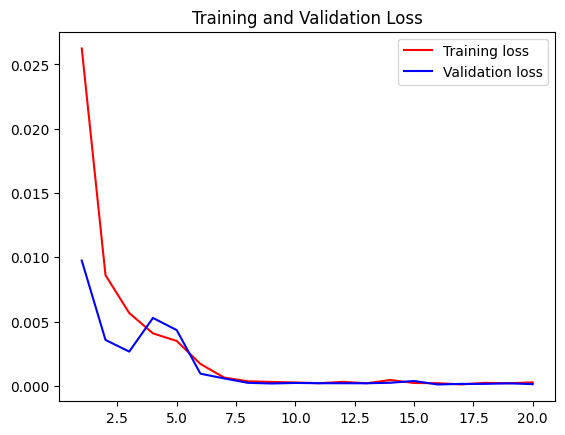

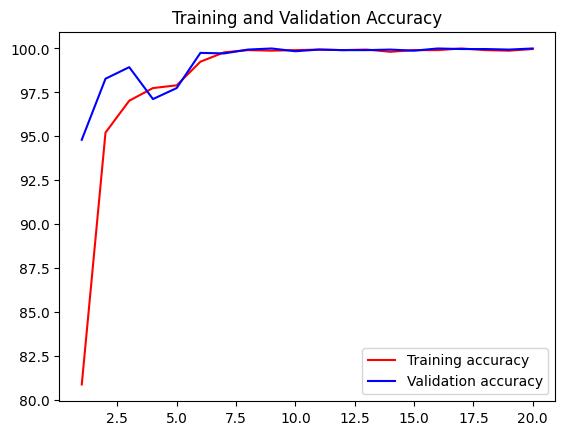

In [ ]:
train(epochs=20)

Accuracy: 100.00%
F1 Score: 1.00
Precision: 1.00
Recall: 1.00


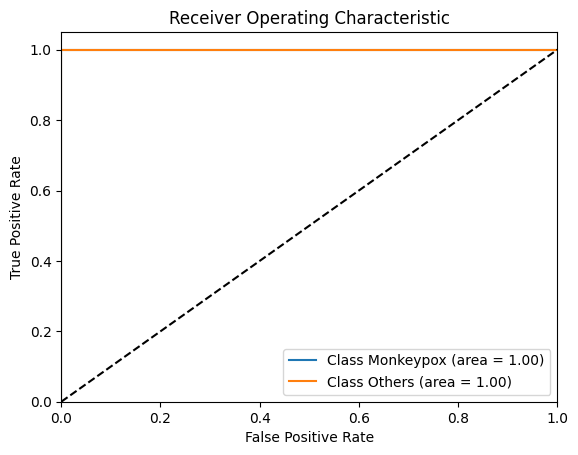

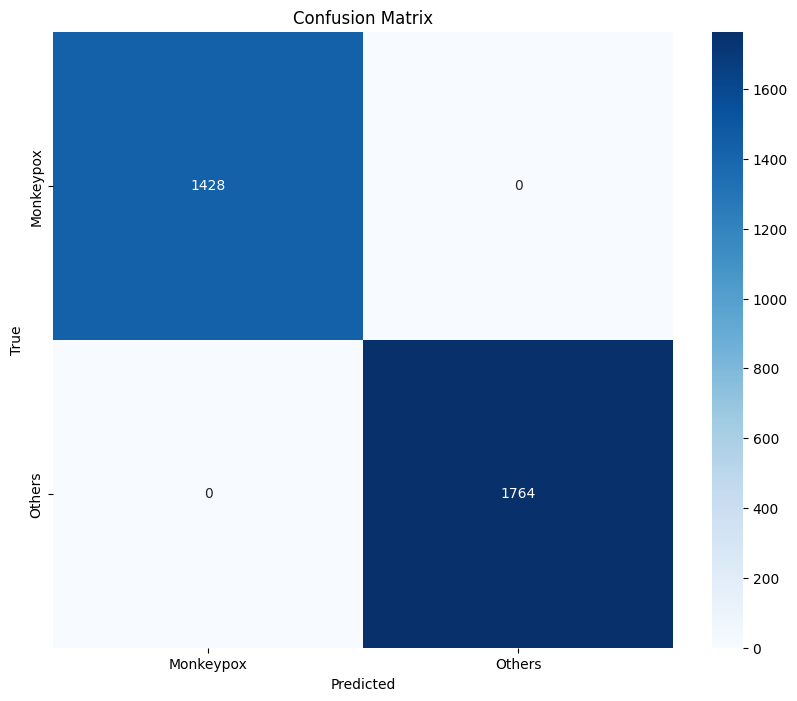

In [ ]:
calculate_accuracy()
calculate_metrics()
plot_roc_curve()
plot_confusion_matrix()

In [ ]:
model_path = "/content/drive/MyDrive/Models/pthFile/cnn_gnn_vit_model-two.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to /content/drive/MyDrive/Models/pthFile/cnn_gnn_vit_model-two.pth


***TEST***

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Dataset, Data,DataLoader
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torchvision import transforms
from PIL import Image
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report



In [ ]:

# CNN-GNN-ViT model class definition
class CNN_GNN_ViT(nn.Module):
    def __init__(self, num_classes):
        super(CNN_GNN_ViT, self).__init__()
        self.vit = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
        in_features = self.vit.heads.head.in_features
        self.vit.heads.head = nn.Linear(in_features, 256)
        self.conv1 = SAGEConv(256, 128)
        self.conv2 = SAGEConv(128, num_classes)

    def forward(self, x, edge_index, batch):
        x = self.vit(x)  
        x = self.conv1(x, edge_index) 
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)  
        return F.log_softmax(x, dim=1)

# Custom dataset class for loading images from subdirectories
class ImageDataset(Dataset):
    def __init__(self, root_dir, class_names, transform=None):
        self.root_dir = root_dir
        self.class_names = class_names
        self.transform = transform
        self.img_paths = []
        self.labels = []

        for class_idx, class_name in enumerate(class_names):
            class_dir = os.path.join(root_dir, class_name)
            img_names = os.listdir(class_dir)
            random.shuffle(img_names)
            selected_imgs = img_names[:100]  

            for img_name in selected_imgs:
                img_path = os.path.join(class_dir, img_name)
                self.img_paths.append(img_path)
                self.labels.append(class_idx)

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label


In [ ]:

# Function to create graph data from image features
def create_graph_data(features):
    num_nodes = features.size(0)
    edge_index = torch.combinations(torch.arange(num_nodes), r=2).t()
    x = features.clone().detach()
    return Data(x=x, edge_index=edge_index)

# Example root directory and class names
root_dir = "/content/drive/MyDrive/MPox/MonkeyPoxSkinLesionDataset"
class_names = ['Monkeypox', 'Others']

model_path = '/content/drive/MyDrive/Models/pthFile/cnn_gnn_vit_model-two.pth'
model = CNN_GNN_ViT(num_classes=len(class_names))
model.load_state_dict(torch.load(model_path))
model.eval()

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:07<00:00, 49.0MB/s]


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Overall Accuracy: 1.00


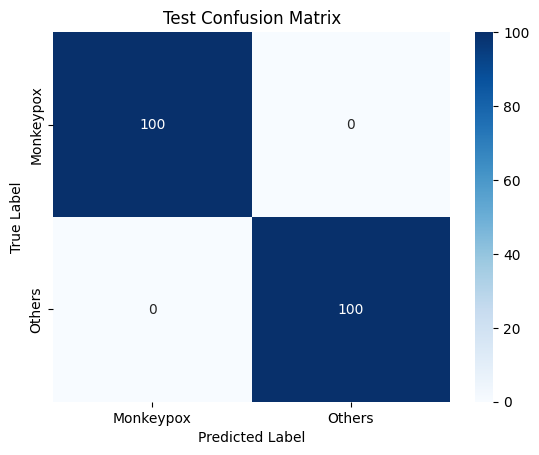

              precision    recall  f1-score   support

   Monkeypox       1.00      1.00      1.00       100
      Others       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



NameError: name 'np' is not defined

<Figure size 640x480 with 0 Axes>

In [ ]:

dataset = ImageDataset(root_dir=root_dir, class_names=class_names, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Testing and metrics calculation
all_labels = []
all_preds = []

with torch.no_grad():
    for img, label in dataloader:
        img = img.to(device)
        data = create_graph_data(img)
        data = data.to(device)

        output = model(data.x, data.edge_index, data.batch)
        _, predicted = torch.max(output.data, 1)
        class_idx = predicted.item()

        all_labels.append(label.item())
        all_preds.append(class_idx)

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Overall Accuracy: {accuracy:.2f}')

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Test Confusion Matrix')
plt.show()

# Classification report
print(classification_report(all_labels, all_preds, target_names=class_names))
